## Exercises 1-2 (Bayes' Theorem)

Example solution provided by Tania Kozynets (AMAS-2021 TA), Feb. 17, 2021; see alternative solution by [Jason](https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/Exercises/Lecture4_Bayes_1.py) (course lecturer).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.special import binom
import matplotlib.ticker as ticker

### My pretty plotting routines

In [2]:
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)


### Setting up the problem

We need to estimate the most likely number of fish in the lake ($N$), given the following information:

* we know that $K$ fish in the lake are of a specific kind (tagged);
* we take $n$ fish from the lake and find that $k$ are tagged. 

The question is, how many fish are there in total? Obviously, $N \geq K$ and $N \geq n$, but we would like to know better, and to build a probability distribution of the $N$ values given the information we collected and any prior knowledge on $N$.

We start by defining the range of $N$ values:

In [3]:
Nrange = np.arange(100,2500,1)

### Defining the priors, the likelihood, and the posterior

What about the prior knowledge? 

As a first guess, we can assume that we don't know anything about $N$ beforehand (hence our "belief model" is flat). 
Another option to test is a prior that falls like $1/N$ (for example, we see that the lake is small, therefore we may assume that it's more likely that there's not a lot of fish in it).

We can encode that prior knowledge in the prior functions below:

In [ ]:
def flat_prior(N):
    flat_line = np.ones_like(N)
    return flat_line
    
def hyperbolic_prior(N):
    hyperbola = 1/N
    return hyperbola

Now, we're getting close to setting up the Bayes theorem, which says that


$P(N|k) = \frac{P(k|N) \cdot P(N)}{P(k)}$ 

where:

* $P(k|N)$ is the likelihood to find $k$ tagged fish from the lake in a sample of $n$ drawn fish, given the total population of $N$; 
* $P(N)$ is the prior on N (defined above); 
* $P(k)$ is the marginal likelihood of drawing $k$ tagged fish from the lake, assuming any $N$ — this shows up as a constant normalization factor, and we won't worry about it for now;
* **$P(N|k)$ is the posterior distribution of the $N$ values, which we seek to compute**. This value answers the question "how likely is it that the total population is $N$, given that $k$ tagged fish were found in a sample of $n$".

Our likelihood function is a hypergeometric probability,


$P(k|N) = \frac{[^k_K \mathrm{C}] \,\, [^{n-k}_{N-k} \mathrm{C}]}{^n_N \mathrm{C}}$,


and the posterior $\propto$ the likelihood $\times $ the prior.

In [5]:
def likelihood(N,K_val,k_val,n_val = 60):
    """Inputs:
    N: range of the tested fish population values;
    K_val: the number of tagged fish in the whole lake;
    n_val: number of fish (tagged + not tagged) drawn in the second round;
    k_val: the number of tagged fish among the n_val drawn.
    
    Returns: the vector of likelihood values for each N.
    """
    return (binom(K_val,k_val)*binom(N-K_val,n_val-k_val)/binom(N,n_val))

def posterior(N,K_val,k_val,n_val = 60,prior=flat_prior):
    #the likelihood times the prior (this is the posterior up to the normalization factor)
    return likelihood(N,K_val,k_val,n_val)*prior(N)

### Computing and plotting the results

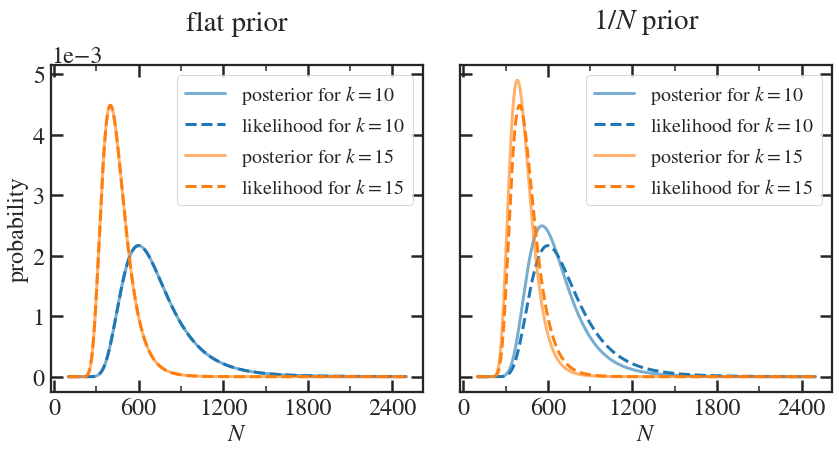

In [6]:
reset_plt(24,24)

fig,axes = plt.subplots(1,2,figsize = (14,6), sharey= 'row')
ax1,ax2 = axes

colors = ['C0','C1']

#placeholder for the "maximum likelihood" estimates of N
N_estimates_hyperbolic_prior = {}

#Looping through the values of k
for ik,k in enumerate([10,15]):
    
    #Computing the likelihood values for the current k and each N in Nrange
    likelihood_values = likelihood(Nrange,K_val=100,k_val=k)
    #Computing the integral of these likelihoods over Nrange 
    #(to normalize everything in the end, we can divide by this integral)
    integrated_likelihood = np.trapz(likelihood_values,Nrange)
    
    #Compuring the posterior values for the current k and each N in Nrange, assuming a FLAT prior on N
    posterior_flat = posterior(Nrange,K_val=100,k_val=k,prior = flat_prior)
    #Integrating the posterior to normalize it afterwards
    integrated_posterior_flat = np.trapz(posterior_flat,Nrange)

    #Plotting the normalized posterior
    ax1.plot(Nrange,posterior_flat/integrated_posterior_flat, 
             lw = 3.0, alpha = 0.6, color = colors[ik],
             label = 'posterior for $k = $%s'%k)
    
    #Plotting the normalized likelihood
    ax1.plot(Nrange,likelihood_values/integrated_likelihood,
             lw = 3.0, ls = '--', color= colors[ik],
             label = 'likelihood for $k = $%s'%k)
    
    
    #Repeating the procedure for the HYPERBOLIC (1/N) prior and the same k setting
    posterior_hyperbolic = posterior(Nrange,K_val=100,k_val=k,prior = hyperbolic_prior)
    
    integrated_posterior_hyperbolic = np.trapz(posterior_hyperbolic,Nrange)
    
    
    ax2.plot(Nrange,posterior_hyperbolic/integrated_posterior_hyperbolic,
             lw = 3.0,alpha = 0.6, color = colors[ik],label = 'posterior for $k = $%s'%k)
    
    
    ax2.plot(Nrange,likelihood_values/integrated_likelihood, 
             lw = 3.0, ls = '--', color= colors[ik],
           label = 'likelihood for $k = $%s'%k)
    
    #Storing the estimates of N that maximize the likelihood and the posterior
    N_estimates_hyperbolic_prior[k] = {'likelihood':Nrange[np.argmax(likelihood_values)],
                                       'posterior':Nrange[np.argmax(posterior_hyperbolic)]}
    
for ax in axes:
    
    ax.set_xlabel('$N$')
    put_ticks(fig,ax)
    ax.legend(loc = 'upper right',fontsize = 20, frameon = True)
    ax.ticklabel_format(axis='x',style='plain')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(600))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(300))


ax1.set_title('flat prior\n')

ax2.set_title(r'1/$N$ prior'+'\n')

ax1.set_ylabel('probability')

fig.subplots_adjust(wspace=0.1)


### Most likely N?

We found that with the flat prior, the likelihood is the same as the posterior (pretty much by definition). 

With the hyperbolic prior, the posterior is shifted to the left with respect to the likelihood, as our prior knowledge tells us that smaller values of $N$ are more likely.

Let's display our "most likely $N$" estimates for the two $k$ settings (10 and 15) we tested.

In [7]:
N_estimates_hyperbolic_prior

{10: {'likelihood': 599, 'posterior': 559},
 15: {'likelihood': 400, 'posterior': 384}}

### Gaussian prior

Now, we will change the form of our prior to gaussian. By doing so, we believe that the population of fish in the lake is roughly some value **N0** but has a $1\sigma$ uncertainty of **sigma**.

In [8]:
def gauss_prior(N,N0,sigma):
    #this is not yet normalized, but we'll take care of it later
    return np.exp(-(N-N0)**2/(2*sigma**2))

What is $\sigma$ in our case? We have two measurements — total volume of the lake, $V_{\mathrm{tot}} \pm \sigma_{V_{\mathrm{tot}}}$, as well as the volume one fish prefers to have for itself, $V_{\mathrm{fish}} \pm \sigma_{V_{\mathrm{fish}}}$. 

The total number of fish is then roughly
<center> $N  = \frac{V_{\mathrm{tot}}}{V_{\mathrm{fish}}}$, </center>

with the uncertainty

<center> $\sigma_N  = N \sqrt {\left( \frac{\sigma_{V_{\mathrm{tot}}}}   {V_{\mathrm{tot}}} \right)^2 + \left( \frac{\sigma_{V_{\mathrm{fish}}}}   {V_{\mathrm{fish}}} \right)^2} $ </center>

Putting this in a function:

In [9]:
def sigmaN(Vtot,sigma_Vtot,Vfish,sigma_Vfish):
    
    N0 = int(Vtot/Vfish)
    
    return N0,N0*np.sqrt((sigma_Vtot/Vtot)**2 + (sigma_Vfish/Vfish)**2)

### The results for a gaussian prior

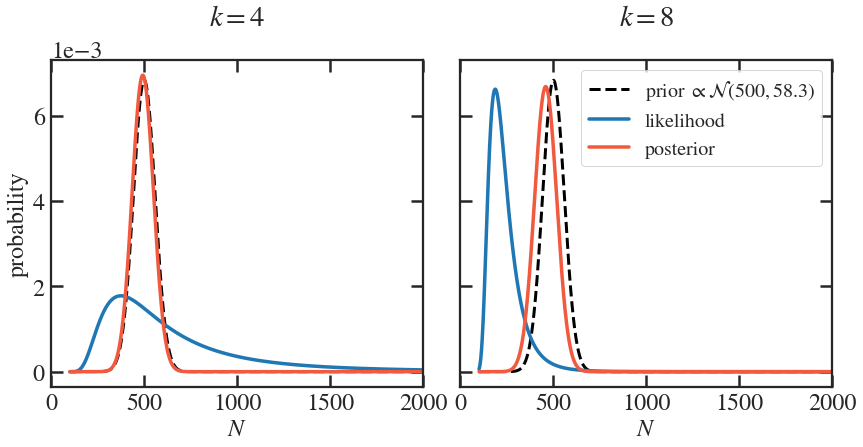

In [10]:
fig,axes = plt.subplots(1,2,figsize = (14,6),sharey=True)
ax1,ax2 = axes

#here the measurements are Vtot = 5000±300 m^3, Vfish = 10±1 m^3, which we can easily modify
gauss_N0,gauss_sigma = sigmaN(Vtot = 5000, sigma_Vtot = 300, Vfish = 10, sigma_Vfish = 1)
#evaluating the prior with the estimated gaussian mean and standard deviation
gauss_prior_values = gauss_prior(Nrange,gauss_N0,gauss_sigma)
#evaluating the integral of the prior so we can normalize it in the end
integrated_prior = np.trapz(gauss_prior_values,Nrange)


#k values to test
k_settings = [4,8]

for ik,k in enumerate(k_settings):

    #Plotting the prior
    axes[ik].plot(Nrange,gauss_prior_values/integrated_prior, lw = 3.0, 
                  label = r'prior $\propto \mathcal{N}(%s,%s)$'%(np.round(gauss_N0,1),
                                                                 np.round(gauss_sigma,1)),
                 color = 'black', ls = '--')

    #Computing the likelihoods with the current k,K,n settings
    likelihood_values = likelihood(Nrange,K_val=50,k_val = k,n_val = 30)
    #Evaluating the integral of the likelihood to normalize it afterwards
    integrated_likelihood = np.trapz(likelihood_values,Nrange)

    #Plotting the normalized likelihood as a function of N
    axes[ik].plot(Nrange,likelihood_values/integrated_likelihood, lw = 3.5,
                 label = 'likelihood')
    
    #Computing the posterior given the above likelihood and a gaussian prior
    #(settings of the gaussian can be tweaked here)
    posterior_values = posterior(Nrange,K_val=50,k_val = k,n_val = 30,
                                 prior = lambda N: gauss_prior(N,N0 = gauss_N0, sigma = gauss_sigma))
    
    #Evaluating the integral of the posterior to normalize it afterwards
    integrated_posterior = np.trapz(posterior_values,Nrange)
    
    #Plotting the normalized posterior as a function of N
    axes[ik].plot(Nrange,posterior_values/integrated_posterior, lw = 3.5,
                 label = 'posterior', color = '#f25a3f')
    
    put_ticks(fig,axes[ik])
    
    axes[ik].set_xlabel('$N$')
    axes[ik].set_title('$k = $%s'%k+'\n')
    
    axes[ik].set_xlim(0,2000)
    axes[ik].ticklabel_format(axis='x',style='plain')
    

axes[1].legend(loc = 'upper right', fontsize = 20,frameon = True)
axes[0].set_ylabel('probability')

fig.subplots_adjust(wspace=0.1)


Now we can adjust the $k$ settings and the parameters of the gaussian prior to explore how they influence our posterior.